This version uses Resnet18.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
import requests, re, time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

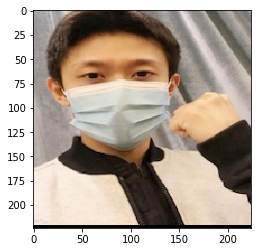

In [ ]:
plt.imshow(dataset_full[0][0].permute(1,2,0))

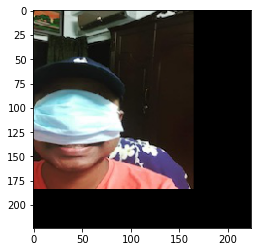

In [ ]:
plt.imshow(dataset_full[2000][0].permute(1,2,0))

In [ ]:
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('./dataset', transform=xform)
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(1549)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
torch.nn.init.xavier_uniform_(model.fc.weight)
device = torch.device('cuda:0')
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

def run_test(model):
    nsamples_test = len(dataset_test)
    loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples)
            loss += criterion(outs, labels)
            _, preds = torch.max(outs.detach(), 1)
            correct_mask = preds == labels
            correct += correct_mask.sum(0).item()
    return loss / nsamples_test, correct / nsamples_test

def run_train(model, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        for samples, labels in loader_train:
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs = model(samples)
            _, preds = torch.max(outs.detach(), 1)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.detach())
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        loss_train, acc_train = run_train(model, optimizer, scheduler)
        loss_test, acc_test = run_test(model)
        print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
#run_test(model)

In [ ]:
run_all(model, optimizer, scheduler, 20)

epoch 0: train loss 0.5526 acc 0.7965, test loss 0.1632 acc 0.7091
epoch 1: train loss 0.3879 acc 0.8677, test loss 0.0393 acc 0.9455
epoch 2: train loss 0.2068 acc 0.9272, test loss 0.0329 acc 0.9554
epoch 3: train loss 0.0958 acc 0.9694, test loss 0.0432 acc 0.9223
epoch 4: train loss 0.0725 acc 0.9826, test loss 0.0317 acc 0.9570
epoch 5: train loss 0.0276 acc 0.9934, test loss 0.0291 acc 0.9587
epoch 6: train loss 0.0201 acc 0.9955, test loss 0.0328 acc 0.9554
epoch 7: train loss 0.0201 acc 0.9963, test loss 0.0292 acc 0.9620
epoch 8: train loss 0.0165 acc 0.9971, test loss 0.0318 acc 0.9603
epoch 9: train loss 0.0153 acc 0.9983, test loss 0.0332 acc 0.9521
epoch 10: train loss 0.0150 acc 0.9971, test loss 0.0314 acc 0.9620
epoch 11: train loss 0.0160 acc 0.9975, test loss 0.0377 acc 0.9537
epoch 12: train loss 0.0148 acc 0.9963, test loss 0.0333 acc 0.9620
epoch 13: train loss 0.0129 acc 0.9988, test loss 0.0319 acc 0.9537
epoch 14: train loss 0.0133 acc 0.9975, test loss 0.0293 a


### Data augmentation


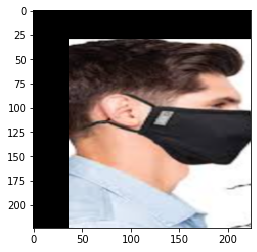

In [ ]:
xform = transforms.Compose([        
        #transforms.RandomResizedCrop(224),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0,translate=(0.2,0.2),scale=(0.8,1.2)),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor()]
)
dataset_full = datasets.ImageFolder('./dataset', transform=xform)
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(1549)
plt.imshow(dataset_full[0][0].permute(1,2,0))
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 32, shuffle=True)

In [ ]:
run_all(model, optimizer, scheduler, 20)

epoch 0: train loss 0.5904 acc 0.7705, test loss 0.0865 acc 0.8413
epoch 1: train loss 0.3958 acc 0.8536, test loss 0.0480 acc 0.9339
epoch 2: train loss 0.2446 acc 0.9132, test loss 0.0433 acc 0.9388
epoch 3: train loss 0.1708 acc 0.9404, test loss 0.0362 acc 0.9471
epoch 4: train loss 0.1579 acc 0.9400, test loss 0.0390 acc 0.9554
epoch 5: train loss 0.0983 acc 0.9677, test loss 0.0295 acc 0.9620
epoch 6: train loss 0.0862 acc 0.9719, test loss 0.0311 acc 0.9554
epoch 7: train loss 0.0750 acc 0.9773, test loss 0.0239 acc 0.9686
epoch 8: train loss 0.0749 acc 0.9748, test loss 0.0261 acc 0.9653
epoch 9: train loss 0.0656 acc 0.9785, test loss 0.0261 acc 0.9603
epoch 10: train loss 0.0646 acc 0.9810, test loss 0.0322 acc 0.9521
epoch 11: train loss 0.0702 acc 0.9797, test loss 0.0278 acc 0.9636
epoch 12: train loss 0.0628 acc 0.9851, test loss 0.0285 acc 0.9587
epoch 13: train loss 0.0611 acc 0.9801, test loss 0.0270 acc 0.9669
epoch 14: train loss 0.0671 acc 0.9777, test loss 0.0262 a

### Test with different parameters and optimizers

**Without Augmentation**:

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch 
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| 0.001           | 0.9    |5     | 0.1  | 4   | 0.0291    | 0.9620    | 7        


**With Augmentation:**

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch 
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| 0.001           | 0.9  |5    | 0.1  | 4   | 0.0251 | 0.9686  | 7 


**Note:** The following training all uses the augmented data since a better accuracy is obtained.

**Adam optimizer:**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
run_all(model, optimizer, scheduler, 20)

epoch 0: train loss 0.6685 acc 0.7225, test loss 0.1043 acc 0.8165
epoch 1: train loss 0.3947 acc 0.8317, test loss 0.1646 acc 0.7488
epoch 2: train loss 0.3269 acc 0.8598, test loss 0.1220 acc 0.7405
epoch 3: train loss 0.3024 acc 0.8809, test loss 0.1081 acc 0.8645
epoch 4: train loss 0.2886 acc 0.8788, test loss 0.0821 acc 0.8760
epoch 5: train loss 0.1592 acc 0.9458, test loss 0.0462 acc 0.9405
epoch 6: train loss 0.1153 acc 0.9595, test loss 0.0453 acc 0.9306
epoch 7: train loss 0.0906 acc 0.9706, test loss 0.0435 acc 0.9306
epoch 8: train loss 0.0609 acc 0.9822, test loss 0.0463 acc 0.9455
epoch 9: train loss 0.0414 acc 0.9917, test loss 0.0536 acc 0.9388
epoch 10: train loss 0.0277 acc 0.9938, test loss 0.0479 acc 0.9339
epoch 11: train loss 0.0196 acc 0.9963, test loss 0.0473 acc 0.9372
epoch 12: train loss 0.0179 acc 0.9963, test loss 0.0533 acc 0.9372
epoch 13: train loss 0.0197 acc 0.9955, test loss 0.0496 acc 0.9438
epoch 14: train loss 0.0154 acc 0.9979, test loss 0.0512 a

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch 
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| 0.001           | 0.9  |5    | 0.1  | 4   | 0.0435 | 0.9455  | 8

**AdamW optimizer:**

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
run_all(model, optimizer, scheduler, 20)

epoch 0: train loss 0.8261 acc 0.5529, test loss 0.1499 acc 0.7322
epoch 1: train loss 0.5988 acc 0.7035, test loss 0.1100 acc 0.8149
epoch 2: train loss 0.5050 acc 0.7738, test loss 0.2932 acc 0.6380
epoch 3: train loss 0.4656 acc 0.7866, test loss 0.1068 acc 0.7967
epoch 4: train loss 0.3743 acc 0.8482, test loss 0.0801 acc 0.8645
epoch 5: train loss 0.2363 acc 0.9074, test loss 0.0623 acc 0.8942
epoch 6: train loss 0.1859 acc 0.9260, test loss 0.0545 acc 0.9058
epoch 7: train loss 0.1569 acc 0.9429, test loss 0.0603 acc 0.8992
epoch 8: train loss 0.1341 acc 0.9516, test loss 0.0520 acc 0.9041
epoch 9: train loss 0.1187 acc 0.9578, test loss 0.0673 acc 0.8843
epoch 10: train loss 0.0744 acc 0.9773, test loss 0.0544 acc 0.9174
epoch 11: train loss 0.0599 acc 0.9806, test loss 0.0565 acc 0.9074
epoch 12: train loss 0.0543 acc 0.9843, test loss 0.0561 acc 0.9190
epoch 13: train loss 0.0453 acc 0.9884, test loss 0.0592 acc 0.9140
epoch 14: train loss 0.0410 acc 0.9868, test loss 0.0578 a

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch 
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| 0.001           | 0.9  |5    | 0.1  | 4   | 0.0561 | 0.9256  | 14

**Note:** The following training all uses the SGD optimizer since a better accuracy is obtained.

**Different parameters**: 

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch 
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| 0.01           | 0.9  |5   | 0.1  | 4  | 0.1606 | 0.6479 | 16 
| 0.0001           | 0.9  |5   | 0.1  | 4  | 0.0385 | 0.9504 | 11 
| 0.001           | 0.85  |5   | 0.1  | 4  | 0.0294 | 0.9636 | 16 
| 0.001           | 0.95  |5   | 0.1  | 4  | 0.0312 | 0.9587 | 15 
| 0.001           | 0.9  |4   | 0.1  | 4  | 0.0259 | 0.9785 | 15 
| 0.001           | 0.9  |6   | 0.1  | 4  | 0.0234 | 0.9653 | 7 
| 0.001           | 0.9  |3   | 0.1  | 4  | 0.0283 | 0.9603 | 15 
| 0.001           | 0.9  |4   | 0.05  | 4  | 0.0242 | 0.9702 | 19 
| 0.001           | 0.9  |4   | 0.15  | 4  | 0.0263 | 0.9686 | 4 
| 0.001           | 0.9  |4   | 0.1  | 16  | 0.0070 | 0.9736 | 12
| 0.001           | 0.9  |4   | 0.05  | 8  | 0.0283 | 0.9636 | 13 
| 0.001           | 0.9  |4   | 0.05  | 32  | 0.0287 | 0.5405 | 13

**Best combination:**

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch 
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| 0.001           | 0.9  |4    | 0.1  | 4   | 0.0259 | 0.9785  | 15 

**Outputs for the optimization settings:**

In [ ]:
run_all(model, optimizer, scheduler, 20) #learning rate = 0.01

epoch 0: train loss 1.9153 acc 0.5124, test loss 0.1993 acc 0.4612
epoch 1: train loss 0.8399 acc 0.5194, test loss 0.1974 acc 0.4595
epoch 2: train loss 0.7787 acc 0.5017, test loss 0.1994 acc 0.5488
epoch 3: train loss 0.7311 acc 0.5372, test loss 0.1782 acc 0.5603
epoch 4: train loss 0.6907 acc 0.5761, test loss 0.2201 acc 0.5901
epoch 5: train loss 0.6762 acc 0.5765, test loss 0.1640 acc 0.6050
epoch 6: train loss 0.6646 acc 0.5827, test loss 0.1749 acc 0.6198
epoch 7: train loss 0.6678 acc 0.5939, test loss 0.1816 acc 0.6050
epoch 8: train loss 0.6653 acc 0.5922, test loss 0.1654 acc 0.6347
epoch 9: train loss 0.6604 acc 0.5926, test loss 0.1640 acc 0.6380
epoch 10: train loss 0.6572 acc 0.5959, test loss 0.1699 acc 0.6182
epoch 11: train loss 0.6567 acc 0.6001, test loss 0.1778 acc 0.6132
epoch 12: train loss 0.6580 acc 0.5906, test loss 0.1762 acc 0.6050
epoch 13: train loss 0.6568 acc 0.6013, test loss 0.1646 acc 0.6231
epoch 14: train loss 0.6552 acc 0.5997, test loss 0.1678 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #learning rate = 0.0001

epoch 0: train loss 0.4983 acc 0.7593, test loss 0.0741 acc 0.8678
epoch 1: train loss 0.3972 acc 0.8205, test loss 0.0595 acc 0.9058
epoch 2: train loss 0.3492 acc 0.8532, test loss 0.0462 acc 0.9306
epoch 3: train loss 0.3213 acc 0.8697, test loss 0.0542 acc 0.9091
epoch 4: train loss 0.2931 acc 0.8759, test loss 0.0436 acc 0.9438
epoch 5: train loss 0.2626 acc 0.8966, test loss 0.0496 acc 0.9355
epoch 6: train loss 0.2624 acc 0.8916, test loss 0.0407 acc 0.9438
epoch 7: train loss 0.2729 acc 0.8867, test loss 0.0415 acc 0.9421
epoch 8: train loss 0.2699 acc 0.8896, test loss 0.0419 acc 0.9355
epoch 9: train loss 0.2491 acc 0.9003, test loss 0.0416 acc 0.9488
epoch 10: train loss 0.2702 acc 0.8879, test loss 0.0409 acc 0.9372
epoch 11: train loss 0.2745 acc 0.8830, test loss 0.0385 acc 0.9504
epoch 12: train loss 0.2633 acc 0.8916, test loss 0.0495 acc 0.9124
epoch 13: train loss 0.2601 acc 0.8908, test loss 0.0415 acc 0.9421
epoch 14: train loss 0.2732 acc 0.8871, test loss 0.0406 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #momentum = 0.85

epoch 0: train loss 0.5147 acc 0.7949, test loss 0.0456 acc 0.9322
epoch 1: train loss 0.3989 acc 0.8424, test loss 0.0888 acc 0.8331
epoch 2: train loss 0.3011 acc 0.8892, test loss 0.0320 acc 0.9636
epoch 3: train loss 0.2256 acc 0.9185, test loss 0.0367 acc 0.9488
epoch 4: train loss 0.1473 acc 0.9462, test loss 0.0389 acc 0.9570
epoch 5: train loss 0.1169 acc 0.9632, test loss 0.0325 acc 0.9554
epoch 6: train loss 0.0954 acc 0.9731, test loss 0.0309 acc 0.9587
epoch 7: train loss 0.0920 acc 0.9723, test loss 0.0350 acc 0.9537
epoch 8: train loss 0.0808 acc 0.9777, test loss 0.0339 acc 0.9570
epoch 9: train loss 0.0909 acc 0.9764, test loss 0.0311 acc 0.9587
epoch 10: train loss 0.0797 acc 0.9768, test loss 0.0314 acc 0.9587
epoch 11: train loss 0.0768 acc 0.9781, test loss 0.0348 acc 0.9471
epoch 12: train loss 0.0779 acc 0.9785, test loss 0.0316 acc 0.9554
epoch 13: train loss 0.0799 acc 0.9789, test loss 0.0326 acc 0.9636
epoch 14: train loss 0.0690 acc 0.9818, test loss 0.0300 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #momentum = 0.95

epoch 0: train loss 0.8949 acc 0.6973, test loss 0.0988 acc 0.8298
epoch 1: train loss 0.5214 acc 0.7932, test loss 0.0786 acc 0.8678
epoch 2: train loss 0.3233 acc 0.8710, test loss 0.0876 acc 0.8727
epoch 3: train loss 0.3307 acc 0.8788, test loss 0.0848 acc 0.8430
epoch 4: train loss 0.2734 acc 0.8912, test loss 0.0601 acc 0.8942
epoch 5: train loss 0.1751 acc 0.9322, test loss 0.0438 acc 0.9322
epoch 6: train loss 0.1575 acc 0.9429, test loss 0.0383 acc 0.9372
epoch 7: train loss 0.1379 acc 0.9483, test loss 0.0342 acc 0.9471
epoch 8: train loss 0.1328 acc 0.9524, test loss 0.0335 acc 0.9438
epoch 9: train loss 0.1233 acc 0.9586, test loss 0.0346 acc 0.9421
epoch 10: train loss 0.1129 acc 0.9648, test loss 0.0322 acc 0.9504
epoch 11: train loss 0.1133 acc 0.9582, test loss 0.0359 acc 0.9488
epoch 12: train loss 0.1139 acc 0.9591, test loss 0.0347 acc 0.9488
epoch 13: train loss 0.1068 acc 0.9636, test loss 0.0326 acc 0.9488
epoch 14: train loss 0.1142 acc 0.9611, test loss 0.0334 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #step size = 4

epoch 0: train loss 0.5783 acc 0.7862, test loss 0.0889 acc 0.8545
epoch 1: train loss 0.3875 acc 0.8557, test loss 0.0466 acc 0.9256
epoch 2: train loss 0.2448 acc 0.9082, test loss 0.1107 acc 0.7934
epoch 3: train loss 0.1913 acc 0.9243, test loss 0.0578 acc 0.9438
epoch 4: train loss 0.1149 acc 0.9620, test loss 0.0259 acc 0.9669
epoch 5: train loss 0.0933 acc 0.9723, test loss 0.0266 acc 0.9636
epoch 6: train loss 0.0923 acc 0.9682, test loss 0.0290 acc 0.9603
epoch 7: train loss 0.0867 acc 0.9711, test loss 0.0290 acc 0.9620
epoch 8: train loss 0.0817 acc 0.9756, test loss 0.0286 acc 0.9702
epoch 9: train loss 0.0783 acc 0.9764, test loss 0.0264 acc 0.9653
epoch 10: train loss 0.0778 acc 0.9793, test loss 0.0276 acc 0.9603
epoch 11: train loss 0.0807 acc 0.9781, test loss 0.0289 acc 0.9636
epoch 12: train loss 0.0779 acc 0.9752, test loss 0.0272 acc 0.9653
epoch 13: train loss 0.0753 acc 0.9756, test loss 0.0281 acc 0.9653
epoch 14: train loss 0.0783 acc 0.9781, test loss 0.0314 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #step size = 6

epoch 0: train loss 0.5885 acc 0.7713, test loss 0.0736 acc 0.8694
epoch 1: train loss 0.3897 acc 0.8482, test loss 0.0406 acc 0.9339
epoch 2: train loss 0.2667 acc 0.8987, test loss 0.0346 acc 0.9504
epoch 3: train loss 0.1781 acc 0.9351, test loss 0.0446 acc 0.9421
epoch 4: train loss 0.1498 acc 0.9438, test loss 0.0493 acc 0.9240
epoch 5: train loss 0.1368 acc 0.9557, test loss 0.0381 acc 0.9471
epoch 6: train loss 0.0837 acc 0.9715, test loss 0.0311 acc 0.9537
epoch 7: train loss 0.0684 acc 0.9806, test loss 0.0313 acc 0.9653
epoch 8: train loss 0.0639 acc 0.9801, test loss 0.0301 acc 0.9554
epoch 9: train loss 0.0672 acc 0.9793, test loss 0.0234 acc 0.9686
epoch 10: train loss 0.0551 acc 0.9839, test loss 0.0277 acc 0.9587
epoch 11: train loss 0.0544 acc 0.9835, test loss 0.0266 acc 0.9570
epoch 12: train loss 0.0576 acc 0.9793, test loss 0.0286 acc 0.9587
epoch 13: train loss 0.0507 acc 0.9818, test loss 0.0289 acc 0.9603
epoch 14: train loss 0.0521 acc 0.9835, test loss 0.0311 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #step size = 3

epoch 0: train loss 0.6199 acc 0.7713, test loss 0.0603 acc 0.9190
epoch 1: train loss 0.4362 acc 0.8375, test loss 0.0478 acc 0.9405
epoch 2: train loss 0.2589 acc 0.9007, test loss 0.0511 acc 0.9174
epoch 3: train loss 0.1618 acc 0.9421, test loss 0.0367 acc 0.9504
epoch 4: train loss 0.1497 acc 0.9516, test loss 0.0340 acc 0.9570
epoch 5: train loss 0.1372 acc 0.9541, test loss 0.0357 acc 0.9471
epoch 6: train loss 0.1227 acc 0.9566, test loss 0.0294 acc 0.9554
epoch 7: train loss 0.1322 acc 0.9520, test loss 0.0325 acc 0.9587
epoch 8: train loss 0.1133 acc 0.9653, test loss 0.0326 acc 0.9471
epoch 9: train loss 0.1255 acc 0.9595, test loss 0.0314 acc 0.9537
epoch 10: train loss 0.1248 acc 0.9582, test loss 0.0333 acc 0.9471
epoch 11: train loss 0.1209 acc 0.9640, test loss 0.0326 acc 0.9537
epoch 12: train loss 0.1232 acc 0.9603, test loss 0.0356 acc 0.9471
epoch 13: train loss 0.1194 acc 0.9624, test loss 0.0347 acc 0.9521
epoch 14: train loss 0.1215 acc 0.9628, test loss 0.0283 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #gamma = 0.05

epoch 0: train loss 0.6363 acc 0.7564, test loss 0.0795 acc 0.8496
epoch 1: train loss 0.3899 acc 0.8391, test loss 0.0447 acc 0.9306
epoch 2: train loss 0.2849 acc 0.8983, test loss 0.0496 acc 0.9339
epoch 3: train loss 0.1923 acc 0.9247, test loss 0.0327 acc 0.9455
epoch 4: train loss 0.1221 acc 0.9615, test loss 0.0288 acc 0.9521
epoch 5: train loss 0.1051 acc 0.9690, test loss 0.0282 acc 0.9587
epoch 6: train loss 0.1054 acc 0.9644, test loss 0.0295 acc 0.9521
epoch 7: train loss 0.0914 acc 0.9711, test loss 0.0259 acc 0.9620
epoch 8: train loss 0.0932 acc 0.9698, test loss 0.0282 acc 0.9636
epoch 9: train loss 0.0995 acc 0.9694, test loss 0.0284 acc 0.9620
epoch 10: train loss 0.0878 acc 0.9739, test loss 0.0265 acc 0.9620
epoch 11: train loss 0.1035 acc 0.9682, test loss 0.0283 acc 0.9521
epoch 12: train loss 0.0914 acc 0.9706, test loss 0.0271 acc 0.9587
epoch 13: train loss 0.0888 acc 0.9690, test loss 0.0276 acc 0.9570
epoch 14: train loss 0.0885 acc 0.9706, test loss 0.0255 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #gamma = 0.15

epoch 0: train loss 0.6301 acc 0.7597, test loss 0.1083 acc 0.8248
epoch 1: train loss 0.4661 acc 0.8342, test loss 0.0415 acc 0.9372
epoch 2: train loss 0.2577 acc 0.9049, test loss 0.0353 acc 0.9554
epoch 3: train loss 0.2113 acc 0.9218, test loss 0.0305 acc 0.9620
epoch 4: train loss 0.1188 acc 0.9632, test loss 0.0283 acc 0.9686
epoch 5: train loss 0.1031 acc 0.9628, test loss 0.0263 acc 0.9653
epoch 6: train loss 0.0908 acc 0.9706, test loss 0.0316 acc 0.9603
epoch 7: train loss 0.0918 acc 0.9723, test loss 0.0265 acc 0.9653
epoch 8: train loss 0.0769 acc 0.9764, test loss 0.0286 acc 0.9620
epoch 9: train loss 0.0757 acc 0.9756, test loss 0.0369 acc 0.9603
epoch 10: train loss 0.0767 acc 0.9768, test loss 0.0275 acc 0.9587
epoch 11: train loss 0.0708 acc 0.9801, test loss 0.0286 acc 0.9636
epoch 12: train loss 0.0742 acc 0.9727, test loss 0.0293 acc 0.9636
epoch 13: train loss 0.0731 acc 0.9764, test loss 0.0291 acc 0.9669
epoch 14: train loss 0.0750 acc 0.9764, test loss 0.0286 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #minibatch = 16

epoch 0: train loss 0.3696 acc 0.8408, test loss 0.0143 acc 0.9107
epoch 1: train loss 0.1983 acc 0.9227, test loss 0.0103 acc 0.9322
epoch 2: train loss 0.1500 acc 0.9483, test loss 0.0087 acc 0.9521
epoch 3: train loss 0.1150 acc 0.9553, test loss 0.0085 acc 0.9455
epoch 4: train loss 0.0914 acc 0.9723, test loss 0.0094 acc 0.9587
epoch 5: train loss 0.0765 acc 0.9777, test loss 0.0089 acc 0.9521
epoch 6: train loss 0.0664 acc 0.9773, test loss 0.0070 acc 0.9504
epoch 7: train loss 0.0531 acc 0.9835, test loss 0.0072 acc 0.9653
epoch 8: train loss 0.0661 acc 0.9789, test loss 0.0083 acc 0.9554
epoch 9: train loss 0.0562 acc 0.9835, test loss 0.0087 acc 0.9537
epoch 10: train loss 0.0740 acc 0.9777, test loss 0.0075 acc 0.9603
epoch 11: train loss 0.0588 acc 0.9785, test loss 0.0084 acc 0.9537
epoch 12: train loss 0.0762 acc 0.9756, test loss 0.0070 acc 0.9736
epoch 13: train loss 0.0618 acc 0.9793, test loss 0.0075 acc 0.9603
epoch 14: train loss 0.0659 acc 0.9764, test loss 0.0069 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #minibatch = 8

epoch 0: train loss 0.6038 acc 0.7647, test loss 0.0477 acc 0.9306
epoch 1: train loss 0.3773 acc 0.8507, test loss 0.0528 acc 0.9058
epoch 2: train loss 0.2577 acc 0.9074, test loss 0.0452 acc 0.9405
epoch 3: train loss 0.1811 acc 0.9380, test loss 0.0299 acc 0.9554
epoch 4: train loss 0.1240 acc 0.9578, test loss 0.0357 acc 0.9455
epoch 5: train loss 0.0994 acc 0.9694, test loss 0.0322 acc 0.9537
epoch 6: train loss 0.0953 acc 0.9698, test loss 0.0296 acc 0.9521
epoch 7: train loss 0.0896 acc 0.9706, test loss 0.0317 acc 0.9521
epoch 8: train loss 0.0815 acc 0.9760, test loss 0.0261 acc 0.9636
epoch 9: train loss 0.0808 acc 0.9727, test loss 0.0301 acc 0.9537
epoch 10: train loss 0.0735 acc 0.9806, test loss 0.0289 acc 0.9537
epoch 11: train loss 0.0801 acc 0.9789, test loss 0.0386 acc 0.9620
epoch 12: train loss 0.0827 acc 0.9752, test loss 0.0303 acc 0.9620
epoch 13: train loss 0.0774 acc 0.9773, test loss 0.0288 acc 0.9636
epoch 14: train loss 0.0862 acc 0.9744, test loss 0.0301 a

In [ ]:
run_all(model, optimizer, scheduler, 20) #minibatch = 32

epoch 0: train loss 0.9528 acc 0.4942, test loss 0.0296 acc 0.5025
epoch 1: train loss 0.9510 acc 0.4988, test loss 0.0287 acc 0.5124
epoch 2: train loss 0.9643 acc 0.4880, test loss 0.0299 acc 0.5091
epoch 3: train loss 0.9485 acc 0.5037, test loss 0.0289 acc 0.5289
epoch 4: train loss 0.9577 acc 0.4847, test loss 0.0294 acc 0.5058
epoch 5: train loss 0.9599 acc 0.4905, test loss 0.0289 acc 0.5140
epoch 6: train loss 0.9450 acc 0.4992, test loss 0.0299 acc 0.5041
epoch 7: train loss 0.9524 acc 0.4942, test loss 0.0297 acc 0.5041
epoch 8: train loss 0.9438 acc 0.5017, test loss 0.0291 acc 0.5289
epoch 9: train loss 0.9633 acc 0.4864, test loss 0.0290 acc 0.5355
epoch 10: train loss 0.9553 acc 0.4938, test loss 0.0293 acc 0.5273
epoch 11: train loss 0.9473 acc 0.4983, test loss 0.0294 acc 0.5355
epoch 12: train loss 0.9446 acc 0.4979, test loss 0.0298 acc 0.5289
epoch 13: train loss 0.9582 acc 0.4921, test loss 0.0290 acc 0.5405
epoch 14: train loss 0.9555 acc 0.4975, test loss 0.0287 a

# Save model

In [ ]:
torch.save(model.state_dict(),'/content/drive/My Drive/model.h5')